In [1]:
import numpy as np, matplotlib.pyplot as plt
from collections import OrderedDict as od
from scipy.special import comb as C
from scipy.stats import linregress
from statistics import median
from scipy.optimize import fminbound
import json
import itertools
from tqdm.notebook import tqdm
from multiprocess import Pool
from magic_functions import calc_hc_tpl

In [2]:
def get_entropy_from_culling_factor_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S

def get_entropy_from_culling_factor_with_heat_v2(c):
    S = od()
    sn = 0
    for E in c:
        S[E] = np.log(c[E])
        S[E] += sn
        sn += np.log(1 - c[E])
    return S


In [40]:
def read_files_v2(parameters, prefix = None):
    q=parameters["q"];
    L=parameters["L"];
    R=parameters["R"];
    D=parameters["D"];
    nSteps=parameters["nSteps"];
    seed=parameters["seed"];
    heat=parameters["heat"];
    N = L * L;
    name = ".{}/2DBlume{}_q{}_D{}_N{}_R{}_nSteps{}_run{}X.txt".format(prefix,"Heating" * heat, q, "{0:07.6f}".format(D), N, R, nSteps, seed)
    print(name)
    culling_factor = od()
    print(N, R, nSteps, heat)
    with open(name) as f:
        for line in f:
            E, c = map(float, line.split())
            culling_factor[E] = c
    parameters["culling_factor"] = culling_factor
    if not heat:
        parameters["S"] = get_entropy_from_culling_factor_v2(culling_factor)
    else:
        parameters["S"] = get_entropy_from_culling_factor_with_heat_v2(culling_factor)
    
    return parameters


def stitch_S(heat, cool):
    #not infinite values
    niv = sorted( list({E for E, S in heat["S"].items() if not np.isinf(S)} &
                       {E for E, S in cool["S"].items() if not np.isinf(S)}) )
    #chosen not infinite values
    cniv = niv[len(niv) // 3 : 2 * len(niv) // 3]
    #print(cniv)
    shift = 0
    count = 0
    for E in cniv:
        shift += heat["S"][E] - cool["S"][E]
        count += 1
    shift /= count

    result = od()
    for E in cool["S"]:
        if E < median(cniv):
            result[E] = cool["S"][E]
    for E in heat["S"]:
        if E >= median(cniv):
            result[E] = heat["S"][E] - shift
    return {"S": result, "L": heat["L"], "D": heat["D"]}


def read_tuple_files(tpl, prefix=None):
    if tpl[1]["heat"]:
        cool = read_files_v2(tpl[0], prefix)
        heat = read_files_v2(tpl[1], prefix)
        return {
            "cool": cool,
            "heat": heat,
            "stitched": stitch_S(heat, cool)
        }


In [69]:
#L_list = [8, 12, 16, 20, 24, 32, 48, 64, 96]
D = 1.95
L = 32
cool, heat = [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": False
}], [{
    "q": 3,
    "D": D,
    "L": L,
    "R" : 131072,
    "nSteps" : 10,
    "seed" : 0,
    "heat": True
}]

parameters = []
for x in zip(cool, heat):
    parameters.append(read_tuple_files(x, '/datasets'))


./datasets/2DBlume_q3_D1.950000_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


./datasets/2DBlumeHeating_q3_D1.950000_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [65]:
parametersAR = []
for x in zip(cool, heat):
    parametersAR.append(read_tuple_files(x, '/datasets/test'))

./datasets/test/2DBlume_q3_D1.962000_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


./datasets/test/2DBlumeHeating_q3_D1.962000_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 True


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [9]:
#coolAR = read_files_v2(cool[0], '/AR_datasets/datasets')

./AR_datasets/datasets/2DBlume_q3_D1.966000_N1024_R131072_nSteps10_run0X.txt
1024 131072 10 False


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


In [9]:
L_list = [8, 12, 16, 20, 24, 32, 48, 64, 96]
[x * x for x in L_list]

[64, 144, 256, 400, 576, 1024, 2304, 4096, 9216]

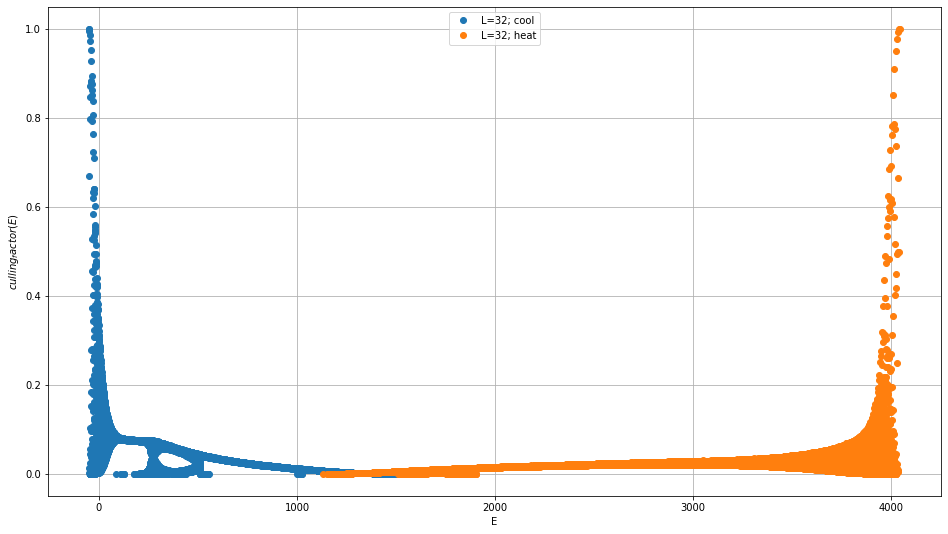

In [70]:
plt.figure(figsize=(16, 9))

i = 0
heat, cool = parameters[i]["heat"], parameters[i]["cool"]

plt.plot([E for E in cool["culling_factor"]], [S for E, S in cool["culling_factor"].items()]
         , 'o', label="L={}; cool".format(cool["L"]))
plt.plot([E for E in heat["culling_factor"]], [S for E, S in heat["culling_factor"].items()]
         , 'o', label="L={}; heat".format(heat["L"]))

plt.ylabel("$culling_factor(E)$")
plt.xlabel("E")
#plt.ylim([-200, -175])
#plt.xlim([-216, -175])
#plt.xlim([-2000, 2000])
plt.legend()
plt.grid()
#plt.savefig("./culling_factor_D{}_L{}.png".format(heat["D"], heat["L"]))

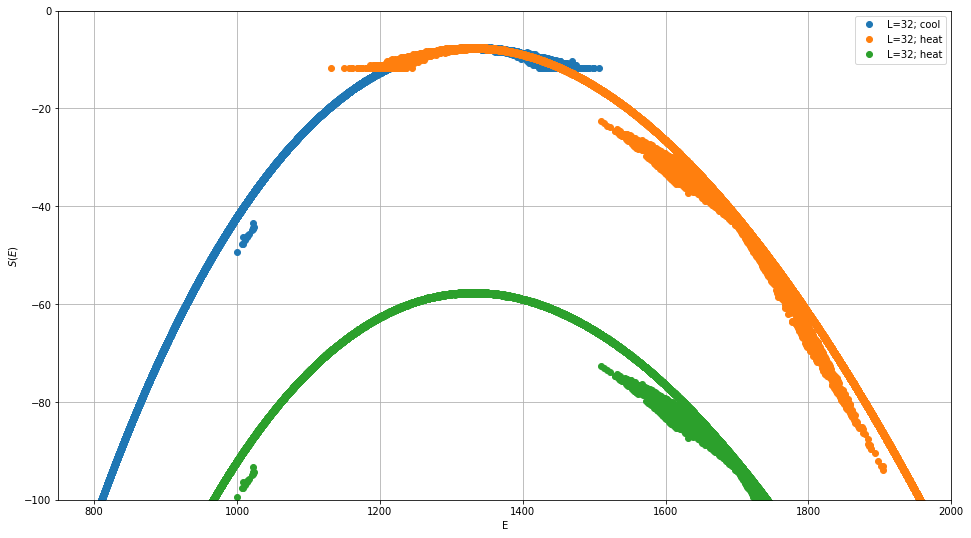

In [71]:
plt.figure(figsize=(16, 9))

i = 0
heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]

plt.plot([E for E in cool["S"]], [S for E, S in cool["S"].items()]
         , 'o', label="L={}; cool".format(cool["L"]))
plt.plot([E for E in heat["S"]], [S for E, S in heat["S"].items()]
         , 'o', label="L={}; heat".format(heat["L"]))
plt.plot([E for E in st["S"]], [S - 50 for E, S in st["S"].items()]
         , 'o', label="L={}; heat".format(heat["L"]))

plt.ylabel("$S(E)$")
plt.xlabel("E")
plt.ylim([-100, 0])
plt.xlim([750, 2000])
#plt.xlim([-2000, 2000])
plt.legend()
plt.grid()
#plt.savefig("./culling_factor_D{}_L{}.png".format(heat["D"], heat["L"]))

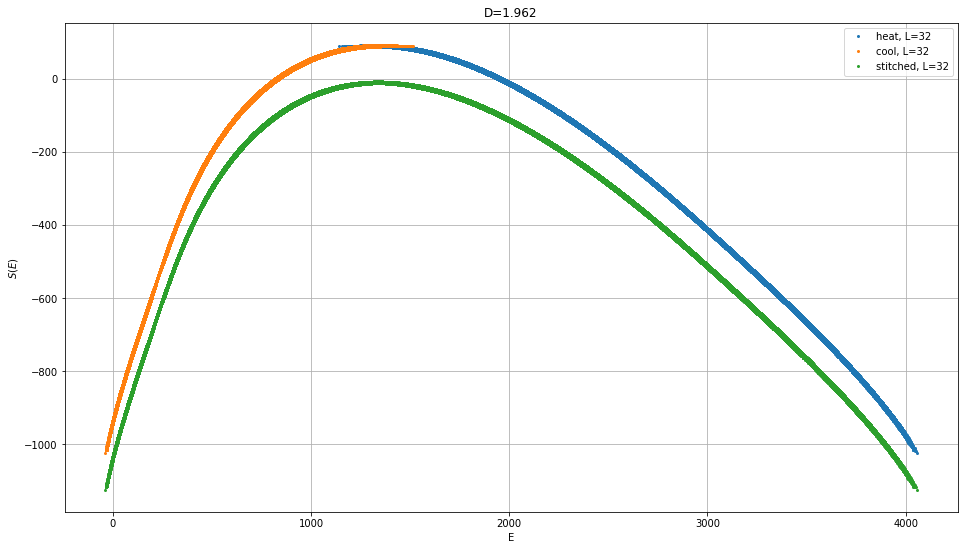

In [68]:
i = 0
heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]

plt.figure(figsize=(16, 9))

plt.plot([E for E in heat["S"]],
         [S + 100 for E, S in heat["S"].items()]
         , 'o', label="heat, L={}".format(cool["L"]), markersize=2)

plt.plot([E for E in cool["S"]],
         [S + 100 for E, S in cool["S"].items()]
         , 'o', label="cool, L={}".format(cool["L"]), markersize=2)

plt.plot([E for E in st["S"]],
         [S for E, S in st["S"].items()]
         , 'o', label="stitched, L={}".format(st["L"]), markersize=2)

plt.ylabel("$S(E)$")
plt.xlabel("E")

plt.title('D={}'.format(st["D"]))
plt.legend()
plt.grid()
#plt.savefig("./S_stitched(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

In [72]:
i = 0
tmp = sorted([(x, parameters[i]['stitched']['S'][x]) for x in parameters[i]['stitched']['S']], key=lambda x: x[0])
tmp_bin = {}
for i in range(0, len(tmp) - 1):
    x = (tmp[i + 1][0] - tmp[i][0])
    #if (x < 0.0001):
    #    print(tmp[i + 1][0], tmp[i][0], tmp[i + 1][0] - tmp[i][0])
    #tmp_bin.append(x)
    if x in tmp_bin:
        tmp_bin[x] += 1
    else:
        tmp_bin[x] = 1

In [73]:
#tmp_bin

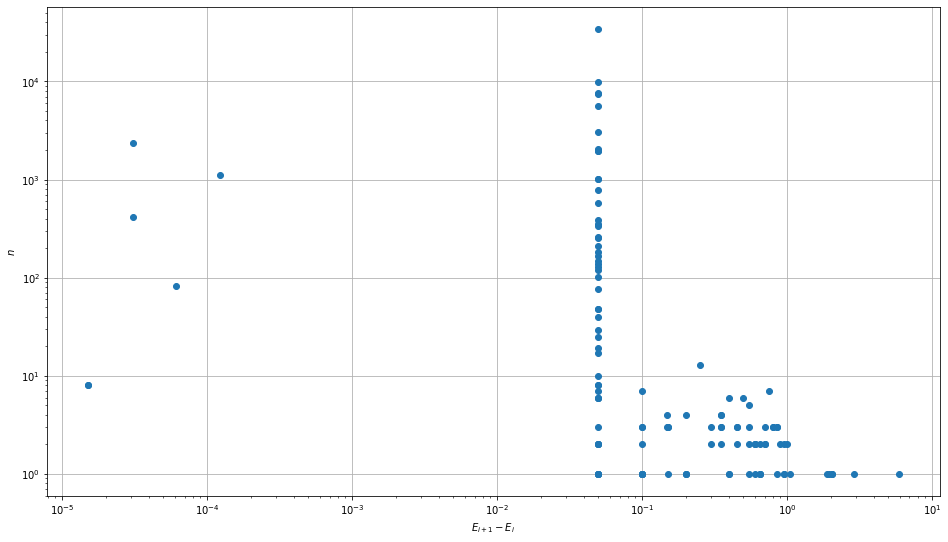

In [74]:
plt.figure(figsize=(16, 9))

plt.plot([x for x in tmp_bin], [tmp_bin[x] for x in tmp_bin], 'o')
#plt.hist(tmp_bin, bins=100)

plt.ylabel("$n$")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("$E_{i+1} - E_i$")
plt.grid()
#plt.savefig("./bin_D{}_L{}.png".format(heat["D"], heat["L"]))

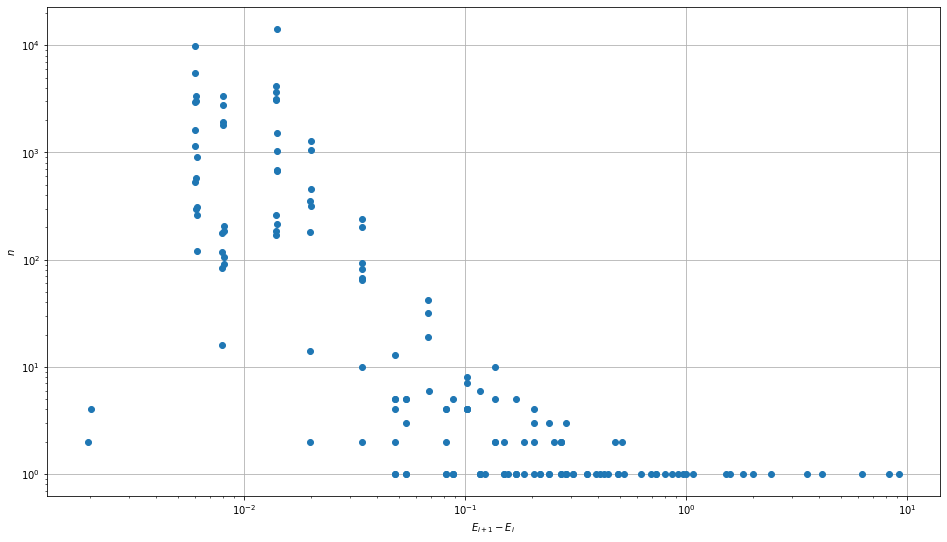

In [33]:
i = 0
tmp = sorted([(x, coolAR['culling_factor'][x]) for x in coolAR['culling_factor']], key=lambda x: x[0])
tmp_bin = {}
for i in range(0, len(tmp) - 1):
    x = (tmp[i + 1][0] - tmp[i][0])
    #if (x < 0.0001):
    #    print(tmp[i + 1][0], tmp[i][0], tmp[i + 1][0] - tmp[i][0])
    #tmp_bin.append(x)
    if x in tmp_bin:
        tmp_bin[x] += 1
    else:
        tmp_bin[x] = 1

plt.figure(figsize=(16, 9))

plt.plot([x for x in tmp_bin], [tmp_bin[x] for x in tmp_bin], 'o')
#plt.hist(tmp_bin, bins=100)

plt.ylabel("$n$")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("$E_{i+1} - E_i$")
plt.grid()


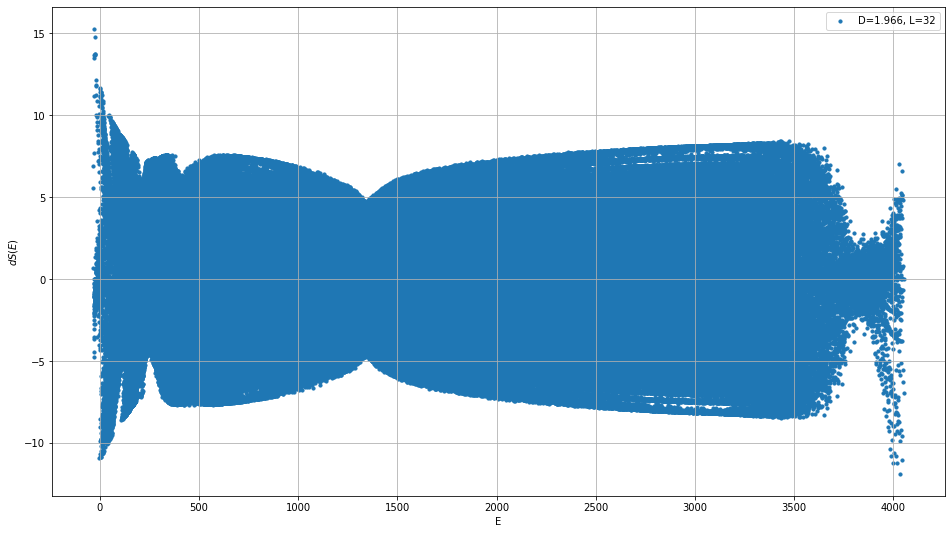

In [30]:
plt.figure(figsize=(16, 9))

plt.scatter([tmp[i][0] for i in range(0, len(tmp) - 1)],
         [tmp[i+1][1]-tmp[i][1] for i in range(0, len(tmp) - 1)],
         label="D={}, L={}".format(st["D"], st["L"]), s=10)

plt.ylabel("$dS(E)$")
plt.xlabel("E")

plt.legend()
plt.grid()
#plt.savefig("./dS(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

In [ ]:
plt.figure(figsize=(16, 9))

plt.scatter([tmp[i][0] for i in range(0, len(tmp) - 1)],
            [tmp[i+1][0]-tmp[i][0] for i in range(0, len(tmp) - 1)]
            , label="D={}, L={}".format(st["D"], st["L"]), s=50)

plt.ylabel("$dE(E)$")
plt.xlabel("E")
#plt.yscale("log")
plt.ylim([-0.01, 4.0])

plt.legend()
plt.grid()
#plt.savefig("./dE(E)_D{}_L{}.png".format(heat["D"], heat["L"]))
#plt.savefig("./dE(E)_D{}_L{}_scale.png".format(heat["D"], heat["L"]))

In [ ]:
plt.figure(figsize=(16, 9))

plt.scatter([tmp[i][0] for i in range(0, len(tmp) - 1)],
            [tmp[i+1][0]-tmp[i][0] for i in range(0, len(tmp) - 1)]
            , label="D={}, L={}".format(st["D"], st["L"]), s=5)

plt.ylabel("$dE(E)$")
plt.xlabel("E")
plt.ylim([-0.05, 1])

plt.legend()
plt.grid()
#plt.savefig("./dE(E)_D{}_L{}_zoom.png".format(heat["D"], heat["L"]))

In [13]:
import mpmath as mp
mp.mp.dps = 50
mp.mp.pretty = True
print(mp.mp)

Mpmath settings:
  mp.prec = 169               [default: 53]
  mp.dps = 50                 [default: 15]
  mp.trap_complex = False     [default: False]


In [ ]:
plt.figure(figsize=(16, 9))

for T in log_progress([0.4, 0.5, 0.55, 0.6, 0.65, 0.7]):
    for i, x in enumerate(parameters):
        heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
        D = st['D']
        L = st['L']
        if L != 32:
            continue
        lst = np.array([mp.exp(mp.mpf(S) - mp.mpf(E) / T) / Z for E, S in st["S"].items()])
        Z = sum(lst)
        plt.plot([E / (L * L) for E in st["S"]],
                 lst / Z
                 , 'o', label="stitched, T={}, L={}".format(T, L))

plt.ylabel('$P(E) = e^{S(E) - E / T} / Z$')
plt.xlabel("E")
plt.xlim([0, 0.5])
plt.title("D={}".format(D))
plt.legend()
plt.grid()
plt.savefig("./P(E)_D{}_L{}.png".format(heat["D"], heat["L"]))

In [ ]:
def calc_hc(st, T):
    E = mp.mpf(0)
    E_sq = mp.mpf(0)
    Z = mp.mpf(0)
    for fe, fS in st['S'].items():
        e = mp.mpf(fe)
        S = mp.mpf(fS)
        w = mp.exp(S - e / T)
        Z += w
        E += w * e
        E_sq += w * e * e
    avgE = E / Z;
    avgE_sq = E_sq / Z;
    return (avgE_sq - avgE * avgE) / (T * T)

In [ ]:
hc = {}

for i, x in enumerate(parameters):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    hc[L] = {}
    for T in log_progress(np.linspace(0.4, 2.0, 20)):
        hc[L][T] = calc_hc(st, T)

In [ ]:
a = 0.4
b = 4.0

In [ ]:
for i, x in enumerate(parameters):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L
    for T in log_progress(np.linspace(a, b, 20)):
        hc[L][T] = calc_hc(st, T)

In [ ]:
T_crit = {}
for i, x in enumerate(parameters):
    st = x["stitched"]
    L = st["L"]
    t, c, _, _ = fminbound(lambda T: - calc_hc(st, T), a, b, maxfun=500, full_output=1, disp=2)
    T_crit[L] = {
        "T_crit": float(t),
        "C_crit": float(-c / (L * L))
    }
T_crit

In [ ]:
D = 1.0

In [ ]:
T_crit

In [ ]:
with open("./tmp/T_crit_D{}.txt".format(D), 'w') as fp:
    json.dump(T_crit, fp)

In [ ]:
#D = heat["D"]


In [ ]:
with open("./tmp/T_crit_D{}.txt".format(D), 'r') as fp:
    T_crit = json.load(fp)
T_crit

In [ ]:
plt.figure(figsize=(16, 9))

for L in T_crit:
    plt.scatter(T_crit[L]['T_crit'], T_crit[L]['C_crit'] / (int(L) * int(L)), label='L={};'.format(L))

    
#plt.plot([Tc, Tc], [0, 3300], label='Tc_their={}'.format(Tc), c='r')
#for L, data in T_crit.items():
#    plt.plot([data['T_crit'], data['T_crit']], [0, 5], label='T_crit_our={:.4f}'.format(float(data['T_crit'])), c='r')

#plt.yscale("log")
plt.title("D={}".format(D))
plt.ylabel('$C(T) / N$')
plt.xlabel("T")
plt.legend()
plt.grid()
#plt.savefig("./C(T)_D{}_L{}.png".format(heat["D"], heat["L"]))
plt.savefig("./C(T)_D{}.png".format(D))

In [ ]:
x = np.array([int(L) for L in T_crit.keys()])
y = np.array([T_crit[L]['T_crit'] for L in T_crit.keys()])
z = np.array([T_crit[L]['C_crit'] / (int(L) * int(L)) for L in T_crit.keys()])

In [ ]:
l = 3
fit = np.polyfit(1 / x[l:], list(map(float, y[l:])), 1, full=False)

plt.figure(figsize=(16, 9))

plt.scatter(1 / x, y)

sample = np.array([0, 0.2])
plt.plot(sample, fit[0] * sample + fit[1], 'r')

plt.title("D={}".format(D))
plt.ylabel('$T_{crit}$')
plt.xlabel("1/L")
#plt.yscale("log")
plt.grid()
plt.legend()
plt.savefig("./finite_size_D{}.png".format(D))

p, V = np.polyfit(1 / x[l:], list(map(float, y[l:])), 1, cov=True)

print("slope: \t{} +/-\n\t{}".format(p[0], np.sqrt(V[0][0])))
print("shift: \t{} +/-\n\t{}".format(p[1], np.sqrt(V[1][1])))


In [ ]:
#np.polyfit(x[1:], list(map(float, y[1:])), 1, full=True)

In [ ]:
plt.scatter(np.log(x), z)

sample = np.array([0, 0.2])
#plt.plot(sample, fit[0] * sample + fit[1], 'r')

plt.title("D={}".format(cool["D"]))
plt.ylabel('$С_{crit} / N$')
plt.xlabel("ln L")
#plt.yscale("log")
plt.legend()
plt.grid()

In [8]:
hc = {}
E = {}
BC = {}

In [9]:
for i, x in enumerate(parameters):
    heat, cool, st = parameters[i]["heat"], parameters[i]["cool"], parameters[i]["stitched"]
    L = st['L']
    N = L * L

    hc[L] = {}
    E[L] = {}
    BC[L] = {}


In [18]:
frames_list = list(zip(itertools.repeat(st), [x for x in np.linspace(0.3, 0.6, 20) if x not in hc[L]]))

with Pool(3) as p:
    pool_outputs = list(
            p.map(calc_hc_tpl, tqdm(frames_list, total=len(frames_list)))
    )

# T, C, average E, BinderCumulant
for tpl in pool_outputs:
    T, x, y, z = tpl
    hc[L][T], E[L][T], BC[L][T] = x, y, z

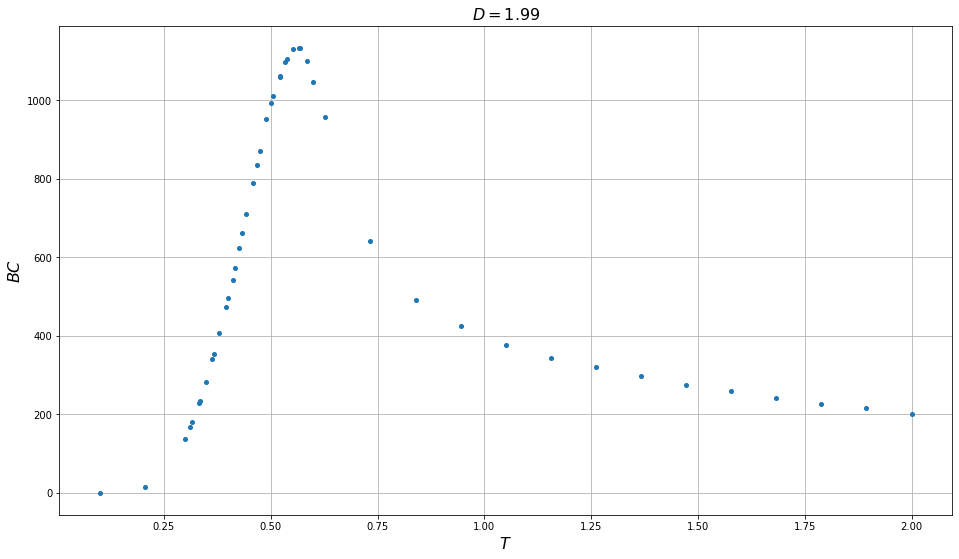

In [19]:
plt.figure(figsize=(16, 9))


plt.plot([float(T) for T in hc[st["L"]]], [c for T, c in hc[st["L"]].items()], 'o', markerSize = 4)
plt.grid()
plt.title("$D={}$".format(st["D"]), fontsize=16)
plt.ylabel('$BC$', fontsize=16)
plt.xlabel('$T$', fontsize=16)
plt.show()